In [1]:
#import the nessesary libraries to used
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import time

In [2]:
#import the csv data file
df = pd.read_csv(r"C:\Users\jay\Desktop\Kwanza Tukule\Data\Cleaned_data.csv")
df.head()

,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE,Month_Year
0,2024-08-18 21:32:00,Category-106,Product-21f4,Business-de42,Location-1ba8,1,850,2024-08
1,2024-08-18 21:32:00,Category-120,Product-4156,Business-de42,Location-1ba8,2,1910,2024-08
2,2024-08-18 21:32:00,Category-121,Product-49bd,Business-de42,Location-1ba8,1,3670,2024-08
3,2024-08-18 21:32:00,Category-76,Product-61dd,Business-de42,Location-1ba8,1,2605,2024-08
4,2024-08-18 21:32:00,Category-119,Product-66e0,Business-de42,Location-1ba8,5,1480,2024-08


In [7]:
df["DATE"] = pd.to_datetime(df["DATE"])

In [9]:
# Calculate Total Value for each transaction
df['Total_Value'] = df['QUANTITY'] * df['UNIT PRICE']

# Set the date as index
df.set_index('DATE', inplace=True)

In [11]:
#Total value series
y =df['Total_Value']
# Resample to hourly frequency and sum the total value
monthly_sales = y.resample("h").sum()
monthly_sales.index.freq = 'h'

monthly_sales.head()

DATE
2024-01-01 05:00:00    23040
2024-01-01 06:00:00        0
2024-01-01 07:00:00     8725
2024-01-01 08:00:00        0
2024-01-01 09:00:00        0
Freq: h, Name: Total_Value, dtype: int64

Plot the caf and pcaf plot so as to examine the correlation coefficients and determine the hyperparamenters for tuning our model

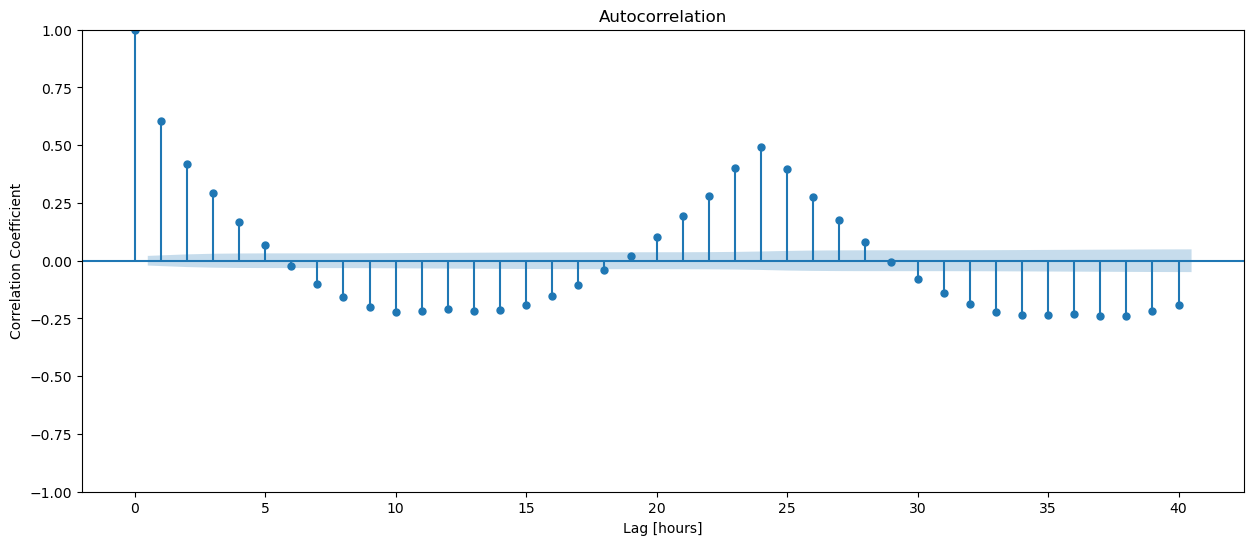

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(monthly_sales, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

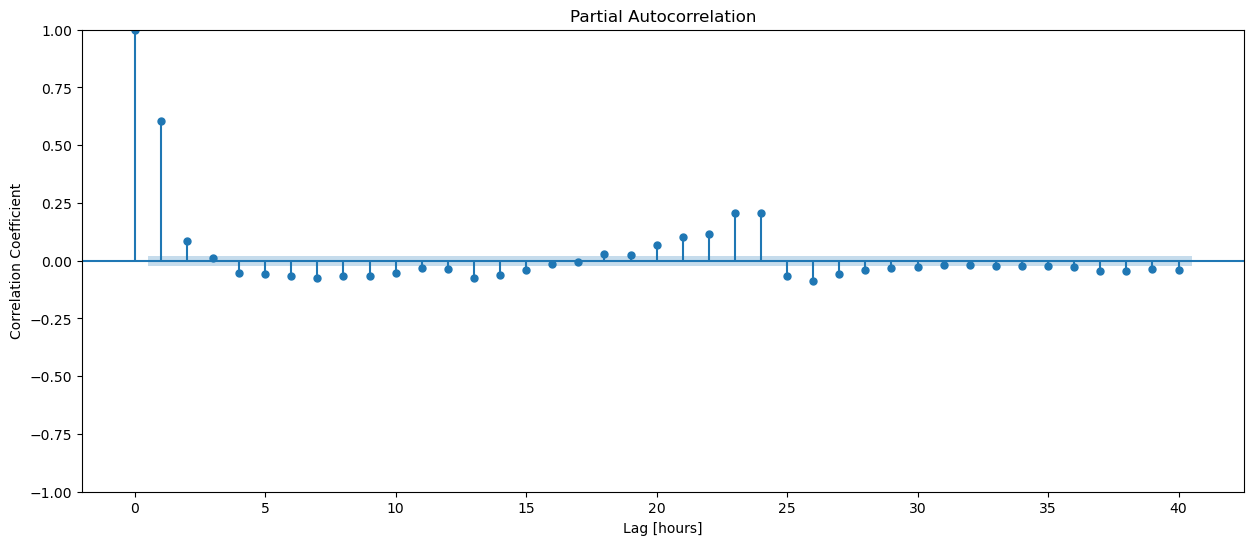

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(monthly_sales, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## SPLIT DATA
I will be splitting the data into 80% training data and 20% test data

In [18]:
#split the data into training data and test data
cutoff_point = int(len(monthly_sales) * 0.8)
y_train = monthly_sales.iloc[:cutoff_point]
y_test = monthly_sales.iloc[cutoff_point:]

In [ ]:
## Building Our Model

In [20]:
#now lets calculate the mean baseline for our model
y_mean = y_train.mean()
mae_baseline = mean_absolute_error(y_train, [y_mean] * len(y_train))
print("Mean monthly sales: ", round(y_mean, 2))
print("Mean baseline: ", round(mae_baseline, 2))

Mean monthly sales:  201410.97
Mean baseline:  242734.01


Now i will be training a model with every combination of hyperparameters in p_params and q_params. Every time the model is trained, the mean absolute error is calculated and then saved to a dictionary.

In [23]:
p_params = range(0,3,1)
q_params = range(0,3,1)

In [25]:
#create a grid for p values and the mean absolute error
mae_grid = {} 
for p in p_params:
    #append p in the grid columns
    mae_grid[p] = []
    for q in q_params:
        order = (p,0,q)
        #start timer
        start_time = time.time()
        #initialize and train the model
        model=ARIMA(y_train, order=order).fit()
        #calculate time used by each combinations
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained arma model: {order} and time used {elapsed_time}")
        #make predictions
        y_pred = model.predict()
        #calculate the mean absolute error
        mae = mean_absolute_error(y_train, y_pred)
        #add the mae to the grid
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained arma model: (0, 0, 0) and time used 2.55
Trained arma model: (0, 0, 1) and time used 3.89
Trained arma model: (0, 0, 2) and time used 5.75
Trained arma model: (1, 0, 0) and time used 3.28
Trained arma model: (1, 0, 1) and time used 7.03
Trained arma model: (1, 0, 2) and time used 8.85
Trained arma model: (2, 0, 0) and time used 3.17
Trained arma model: (2, 0, 1) and time used 12.39
Trained arma model: (2, 0, 2) and time used 21.65

{0: [242734.00724782576, 189382.0955957507, 172432.82311446776], 1: [156482.5725003272, 154415.0119749894, 154384.43287328162], 2: [154451.71241839643, 154400.25998642616, 150779.44875040464]}


In [27]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2
0,242734.0072,156482.5725,154451.7124
1,189382.0956,154415.0120,154400.2600
2,172432.8231,154384.4329,150779.4488


We Choose hyperparameters  that will result to a mean absolute error near oue baseline mean and also we consider the perfomance that will require less resources to perform our 3months forecast

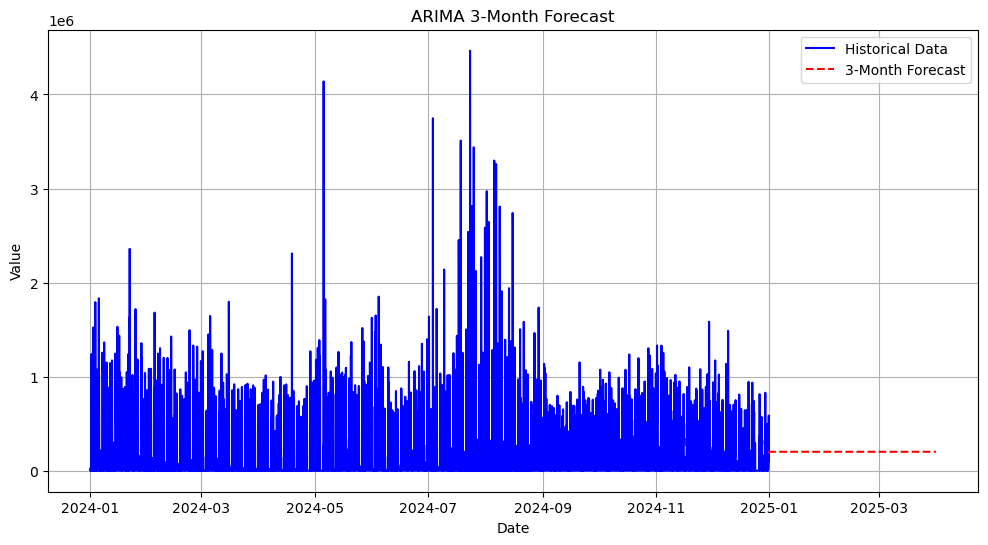

In [30]:
#forecast for the next three months
# Define ARIMA order (p, d, q) - You might need to tune this
order = (2, 0, 0)  

# Train the ARIMA model
model = ARIMA(monthly_sales, order=order).fit()

# Forecast for 3 months (2160 hours)
forecast_steps = 90 * 24  # 3 months in hours
forecast = model.forecast(steps=forecast_steps)

# Create future time index
future_index = pd.date_range(start=monthly_sales.index[-1], periods=forecast_steps + 1, freq='h')[1:]

# Convert forecast to Pandas Series
forecast_series = pd.Series(forecast, index=future_index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales, label="Historical Data", color='blue')
plt.plot(forecast_series.index, forecast_series, label="3-Month Forecast", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("ARIMA 3-Month Forecast")
plt.legend()
plt.grid()
plt.show()

Now we perform a walk-forward validation for our model since our model is not perfoming well.Lets store the model's predictions in the Series y_pred_wfv.  Lets Choose the values for  𝑝 and  𝑞 that best balance model performance and computation time.

In [36]:
y =df['Total_Value']
# Resample to hourly frequency and sum the total value
monthly_sale = y.resample("ME").sum()

In [40]:
# Ensure the index has a monthly frequency
monthly_sale.index = pd.to_datetime(monthly_sale.index)
monthly_sale.index.freq = 'ME'  # 'ME' stands for Month End frequency

In [48]:
monthly_sale.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 12 entries, 2024-01-31 to 2024-12-31
Freq: ME
Series name: Total_Value
Non-Null Count  Dtype
--------------  -----
12 non-null     int64
dtypes: int64(1)
memory usage: 192.0 bytes


C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provid

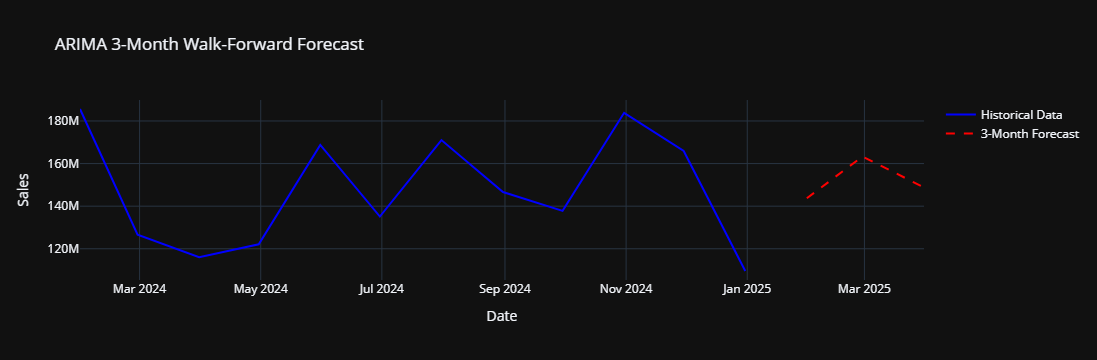

In [56]:
# Define ARIMA order
order = (2, 0, 0)

# Set number of forecast steps (3 months)
forecast_steps = 3

# Ensure the index has a monthly frequency
monthly_sale.index = pd.to_datetime(monthly_sale.index)
if monthly_sale.index.freq is None:
    monthly_sale = monthly_sale.asfreq('ME')  # Set to month-end frequency

# Initialize history with all available data
history = monthly_sale.copy()
predictions = []

# Create future time index for 3-month period with the same frequency
future_index = pd.date_range(start=monthly_sale.index[-1], periods=forecast_steps + 1, freq=monthly_sale.index.freq)[1:]

# Walk-forward forecasting for 3 months
for t in range(forecast_steps):
    # Train ARIMA model on expanding dataset
    model = ARIMA(history, order=order).fit()
    
    # Forecast next step
    next_pred = model.forecast(steps=1).iloc[0]
    
    # Store prediction
    predictions.append(next_pred)
    
    # Append predicted value to history (roll forward)
    new_point = pd.Series([next_pred], index=[future_index[t]])
    history = pd.concat([history, new_point])

# Convert predictions to Pandas Series
forecast_series = pd.Series(predictions, index=future_index)

# Plot using Plotly
fig = px.line(title="ARIMA 3-Month Walk-Forward Forecast", template="plotly_dark")

# Add historical data
fig.add_scatter(x=monthly_sale.index, y=monthly_sale.values, mode='lines', name="Historical Data", line=dict(color="blue"))

# Add walk-forward forecast
fig.add_scatter(x=forecast_series.index, y=forecast_series.values, mode='lines', name="3-Month Forecast", line=dict(color="red", dash="dash"))

# Customize layout
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x",
)

# Show plot
fig.show()


C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\jay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provid

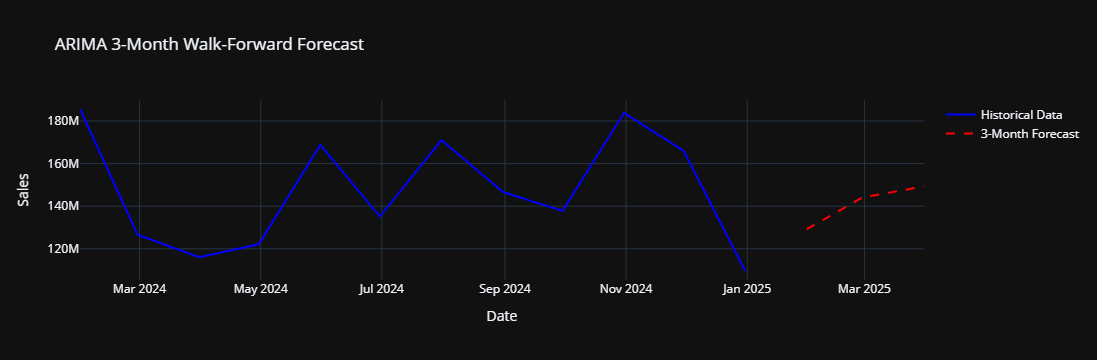

In [52]:
# Define ARIMA order
order = (2, 0, 1)

# Set number of forecast steps (3 months)
forecast_steps = 3

# Ensure the index has a monthly frequency
monthly_sale.index = pd.to_datetime(monthly_sale.index)
if monthly_sale.index.freq is None:
    monthly_sale = monthly_sale.asfreq('ME')  # Set to month-end frequency

# Initialize history with all available data
history = monthly_sale.copy()
predictions = []

# Create future time index starting from January 1st, 2025
future_index = pd.date_range(start='2025-01-01', periods=forecast_steps, freq='ME')

# Walk-forward forecasting for 3 months
for t in range(forecast_steps):
    # Train ARIMA model on expanding dataset
    model = ARIMA(history, order=order).fit()
    
    # Forecast next step
    next_pred = model.forecast(steps=1).iloc[0]
    
    # Store prediction
    predictions.append(next_pred)
    
    # Append predicted value to history (roll forward)
    new_point = pd.Series([next_pred], index=[future_index[t]])
    history = pd.concat([history, new_point])

# Convert predictions to Pandas Series
forecast_series = pd.Series(predictions, index=future_index)

# Plot using Plotly
fig = px.line(title="ARIMA 3-Month Walk-Forward Forecast", template="plotly_dark")

# Add historical data
fig.add_scatter(x=monthly_sale.index, y=monthly_sale.values, mode='lines', name="Historical Data", line=dict(color="blue"))

# Add walk-forward forecast
fig.add_scatter(x=forecast_series.index, y=forecast_series.values, mode='lines', name="3-Month Forecast", line=dict(color="red", dash="dash"))

# Customize layout
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x",
)

# Show plot
fig.show()

In [58]:
forecast_series

2025-01-31    1.436849e+08
2025-02-28    1.633471e+08
2025-03-31    1.488009e+08
Freq: ME, dtype: float64